# Pregunta 1

El hardware utilizado se compone de los siguientes:

- Procesador	11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz, 2419 Mhz, 4 procesadores principales, 8 procesadores lógicos
- Memoria física instalada (RAM)	8,00 GB

Importamos las librerías necesarias.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import gamma
from scipy.stats import chi2
import timeit

Para simular desde la densidad objetivo con $k,V$, utilizaremos el algoritmo `Aceptación-Rechazo` con densidad instrumental la misma densidad objetivo, pero con $\lfloor k\rfloor,V$. Para $k$ entero haremos uso del siguiente resultado visto en Análisis Estadístico Multivariado MAT269.

Suponga que $\mathbf{z_1}, \mathbf{z_2}, \ldots, \mathbf{z_k}$ son vectores IID desde $N_p(\mathbf{0}, \mathbf{V})$. Entonces
$$\mathbf{W} = \sum_{i=1}^{k} \mathbf{z_i}\mathbf{z_i}^\top \sim W_p(k, \mathbf{V}).$$ 

Para el valor de la constante $M$ creamos una función que realiza la búsqueda de $M$ tal que $f(\mathbf{X} | k,\mathbf{V}) / f(\mathbf{X} | \lfloor k\rfloor,\mathbf{V}) \leq 1$ para diferentes $\mathbf{X}$ simulados desde la densidad instrumental. 

Definimos las funciones a utilizar.

In [2]:
def gen_X(n, V):
    X = np.zeros_like(V)
    for _ in range(n):
        z0 = np.random.normal(0,1,(V.shape[0],1)) 
        X += z0 @ z0.T
    L = np.linalg.cholesky(V)
    return L @ X @ L.T

def gamma_p(p, x):
    prod = 1
    for j in range(1,p+1):
        prod *= gamma(x-(j-1)/2)
    return np.pi**(p*(p-1)/4) * prod

def f(X, k, V):
    p = X.shape[0]
    dets = np.linalg.det(X)**((k-p-1)/2)/np.linalg.det(V)**(k/2) if p>1 else float(X)**((k-p-1)/2)/float(V)**(k/2)
    exp  = np.exp(-0.5*np.trace(np.linalg.inv(V)@X)) if p>1 else np.exp(-0.5*float(X)/float(V)) 
    return dets * exp / (2**(k*p/2) * gamma_p(p, k/2))

In [3]:
def buscar_M(k, V):
    M = 1
    cont = 0
    while cont<1_000:
        X = gen_X(int(k), V)
        if f(X,k,V)/(M*f(X,int(k),V)) > 1:
            cont = 0
            M += 0.1
        cont += 1
    return M

def accept_reject(n_examples, k, V, M):
    n, rechazados, aceptados = 0, 0, []
    while n<n_examples:
        X = gen_X(int(k), V)
        if np.random.uniform() <= f(X,k,V)/(M*f(X,int(k),V)):
            aceptados.append(X)
            n+=1
        else:
            rechazados+=1
    return aceptados, rechazados

Para ver el funcionamiento de los códigos, analizamos el caso de $p=1$, ya que es graficable, con $k=5.5$ y $\mathbf{V} = 2$.

In [4]:
p, k = 1, 5.5
V = 2*np.eye(1)
M = buscar_M(k,V)
aceptados, _ = accept_reject(10_000, k, V, M)

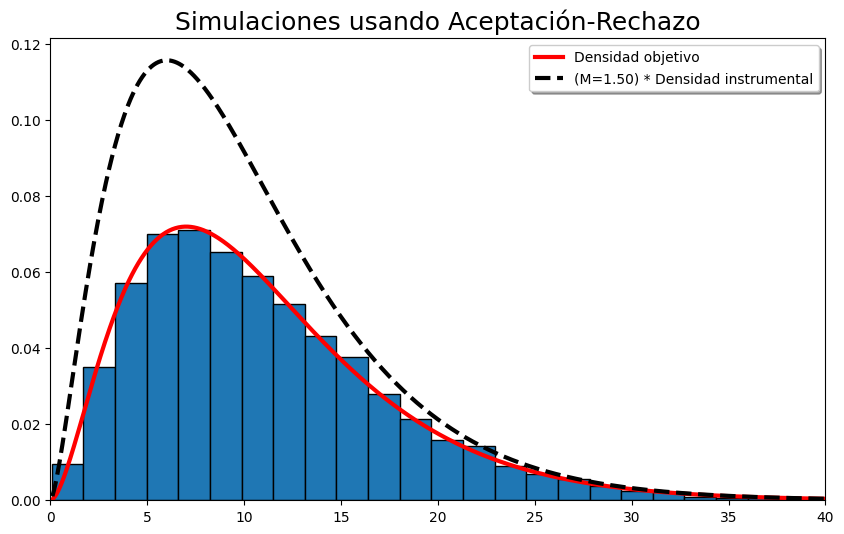

In [5]:
plt.figure(figsize=(10,6))
# Histograma
plt.hist(np.array(aceptados).flatten(), density=True, bins=30, edgecolor='k')

x = np.linspace(0.1,40,1_000)
# Densidad objetivo
plt.plot(x, [f(np.array([xx]),k,V) for xx in x], lw=3, c='r', label='Densidad objetivo')
# Densidad instrumental
plt.plot(x, [M*f(np.array([xx]),int(k),V) for xx in x], lw=3, ls='--', c='k', label=f'({M=:.2f}) * Densidad instrumental')
plt.title('Simulaciones usando Aceptación-Rechazo', size=18)
plt.xlim(0,40); plt.legend(shadow=True)
path = 'C:/Users/Aleja/OneDrive - Universidad Técnica Federico Santa María/Material universidad/10sem 2023-2/MAT468/MAT468_github/certamen/P1/'
plt.savefig(path+'P1_ejemplo_1dim.png');

Midamos los tiempos de computo del algoritmo para distintos valores de $p$, usando $k=1002$ fijo para que sea comparable el problema y $\mathbf{V}=\mathbf{I_p}$, ejecutaremos para valores de $p$ tal que $k>p-1$.

In [6]:
%%time
ps = range(1,1002,40)
times = [timeit.timeit(lambda: gen_X(1002, np.eye(p)), number=1) for p in ps]

CPU times: total: 33 s
Wall time: 1min


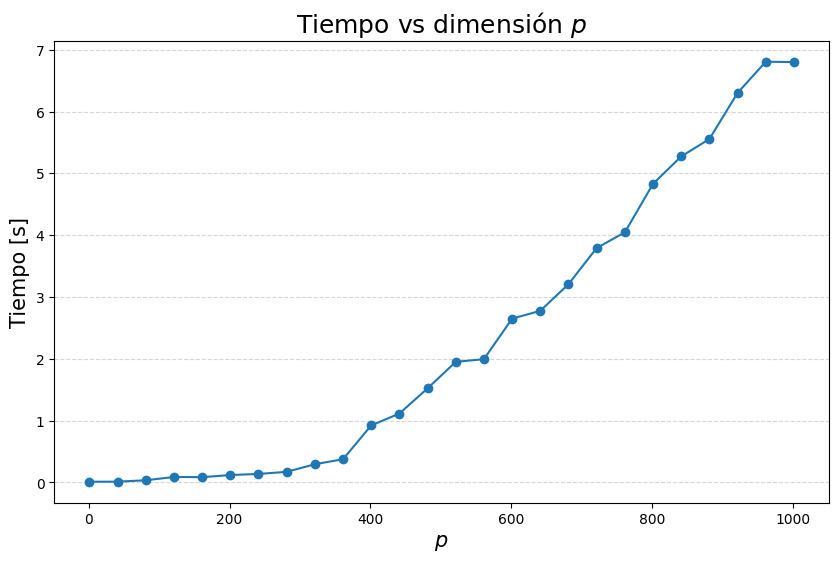

In [7]:
plt.figure(figsize=(10,6))

plt.plot(ps, times,'o-')

plt.title(r'Tiempo vs dimensión $p$', size=18)
plt.xlabel(r'$p$', size=15); plt.ylabel('Tiempo [s]', size=15)
plt.grid(axis='y', alpha = 0.5, ls='--')
plt.savefig(path+'P1_tiempos_vs_p.png');

Visualicemos los resultados de utilizar `Aceptación-Rechazo` para $p=10$, $k=p+\varepsilon_0$, $\mathbf{V}=\operatorname{diag}(\varepsilon_1, \ldots, \varepsilon_p)$ donde $\varepsilon_i\sim U(0,1)$. Fijamos los valores para obtener resultados, pero se puede modificar esos parámetros en la siguiente celda.

In [8]:
p = 10
k = p + np.random.RandomState(41).uniform()
V = np.diag(np.random.RandomState(42).uniform(0,1,p))

Buscamos el valor de M mediante simulaciones:

In [9]:
%%time
M = buscar_M(k, V)
M

CPU times: total: 672 ms
Wall time: 1.97 s


2.4000000000000012

In [10]:
print(f'Se espera la siguiente tasa de aceptación: {1/M:.2%}')

Se espera la siguiente tasa de aceptación: 41.67%


In [11]:
%%time
n_examples = 1_000
aceptados, rechazados = accept_reject(n_examples, k, V, M)

CPU times: total: 766 ms
Wall time: 1.84 s


In [12]:
print(f'Se obtuvo la siguiente tasa de aceptación: {n_examples/(n_examples+rechazados):.2%}')

Se obtuvo la siguiente tasa de aceptación: 40.11%


Justifiquemos que el método de simulación funciona, haremos uso de los resultados esperados de la __Obs 3__.

Para ver que $\mathbb{E}[\mathbf{X}] = k\mathbf{V}$, calcularemos el error absoluto de cada entrada de la matriz, visualizandolo en un mapa de calor.

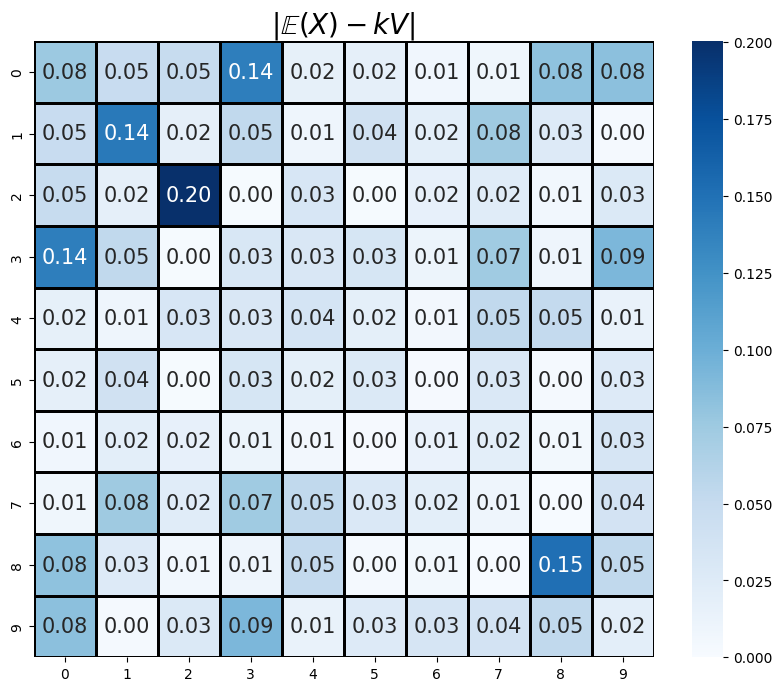

In [13]:
plt.figure(figsize=(10,8))
sns.heatmap(np.abs(np.mean(aceptados,axis=0)-k*V), annot=True, cmap="Blues",
            annot_kws={"size":15}, fmt=".2f", vmin=0, #vmax=.1,
            linecolor='k', linewidths=1
            )
plt.title(r'$|\mathbb{E}(X)-kV|$', size = 20)
plt.savefig(path + 'P1_comp_esperanza.png');

In [14]:
np.linalg.norm(np.mean(aceptados,axis=0)-k*V)

0.5097316118185072

Para probar mediante las simulaciones que $\operatorname{var}(\mathbf{X}_{ij}) = k \left(v_{ij}^2+v_{ii}v_{jj}\right)$ para todo $i,j$, calcularemos la varianza de cada coordenada de las simulaciones generadas y las compararemos en una gráfico de dispersión, esperamos que estos puntos estén cercanos a la identidad, lo que nos dice que son iguales.

In [15]:
def var_esperada(k, V):
    var_ = np.zeros_like(V)
    for i in range(var_.shape[0]): 
        for j in range(var_.shape[1]):
            var_[i,j] = k * ( V[i,j]**2 + V[i,i] * V[j,j])
    return var_

var_espe = var_esperada(k, V)
var_mues = np.var(aceptados, axis=0)

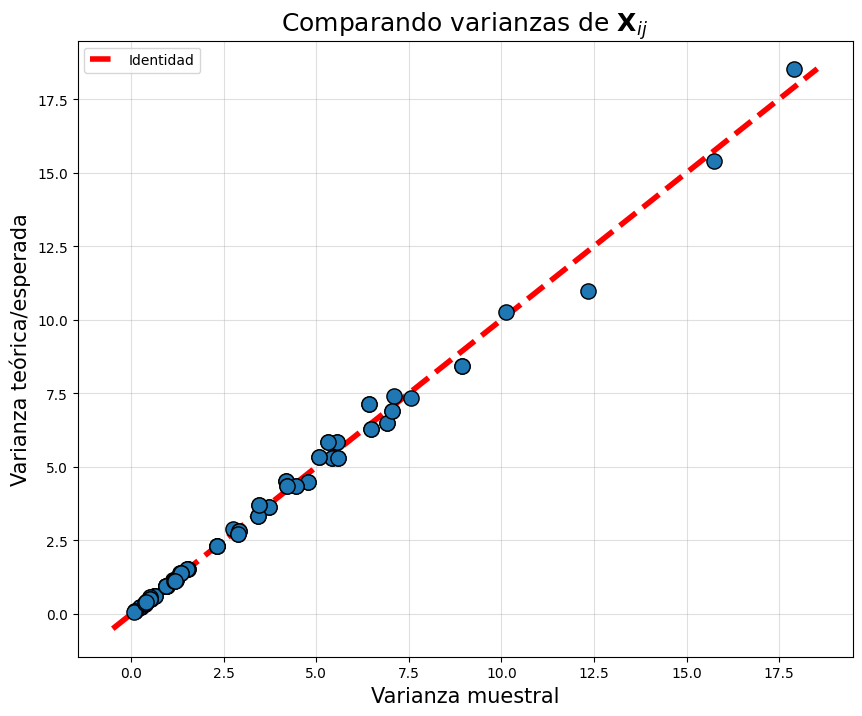

In [16]:
plt.figure(figsize=(10,8))

plt.plot([-0.5, max(var_espe.max(), var_mues.max())],
         [-0.5, max(var_espe.max(), var_mues.max())],
         lw = 4, ls = '--', c = 'r', zorder = 1,
         label = 'Identidad'
         )
plt.scatter(var_mues.flatten(), var_espe.flatten(),
            s=120, edgecolors='k', zorder=2)
plt.grid(alpha=0.4, zorder=0)
plt.xlabel('Varianza muestral', size=15)
plt.ylabel('Varianza teórica/esperada', size=15)
plt.title(r'Comparando varianzas de $\mathbf{X}_{ij}$', size = 18)
plt.legend()
plt.savefig(path + 'P1_varianzas')

Finalmente, por la teoría sabemos que $\mathbf{X}_{ii} \sim v_{ii} \chi^2_{k}$ para todo $i=1,\ldots,p$. Para poder visualizar si esto se cumple experimentalmente a través de las simulaciones realizadas, haremos el histograma de $\mathbf{X}_{ii} / v_{ii}$ lo que debería seguir una $\chi^2_{k}$. Haremos el histograma para cada coordenada de la diagonal de las simulaciones.

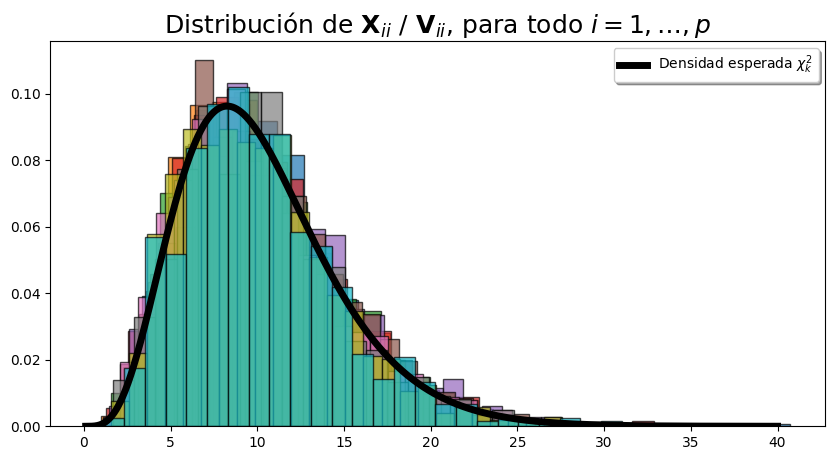

In [17]:
plt.figure(figsize=(10,6))
for i in range(p):
    plt.hist(np.array(aceptados)[:, i, i]/V[i,i], density=True, bins=25, edgecolor='k', alpha=0.7)

x = np.linspace(0.1,40,1_000)
plt.plot(x, chi2(k).pdf(x), lw=5, c='k', label=r'Densidad esperada $\chi^2_k$')

plt.title(r'Distribución de $\mathbf{X}_{ii} ~/~ \mathbf{V}_{ii}$, para todo $i=1,\ldots,p$', size=18)
plt.legend(shadow=True)
plt.savefig(path+'P1_distr_coord_diag.png');